In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV 
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, LSTM
from keras.layers import Dropout
from keras import backend as K

In [3]:
new_df = pd.read_csv("/content/drive/MyDrive/new_df.csv")
new_df.drop(columns = 'Unnamed: 0', inplace=True)

In [4]:
#normalizing
scaler = StandardScaler()
new_df.iloc[:, 6:496] = scaler.fit_transform(new_df.iloc[:, 6:496])

## Density diagarams of the different variables per class

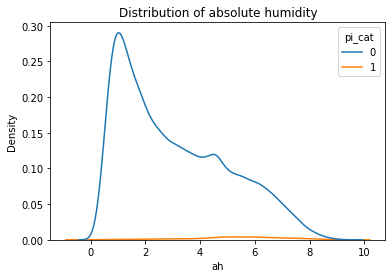

In [27]:
new_df.pi_cat = np.where(new_df.pi24>15,1,0)

sns.kdeplot(new_df.ah, hue = new_df.pi_cat).set(title='Distribution of absolute humidity')
plt.savefig('pics.png', dpi=300)

In [5]:
split_index = round(new_df.shape[0] * 0.8)

test = new_df[split_index:]
new_df = new_df[:split_index]

# KNN

In [30]:
KNN = KNeighborsClassifier(n_neighbors=1, metric='cosine', n_jobs=-1)

KNN.fit(X = new_df.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]], y = new_df.loc[:, 'pi_cat'])

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=1)

In [31]:
preds = KNN.predict(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])

In [32]:
confusion_matrix(test.loc[:, 'pi_cat'], preds)

array([[33592,   568],
       [  650,   156]])

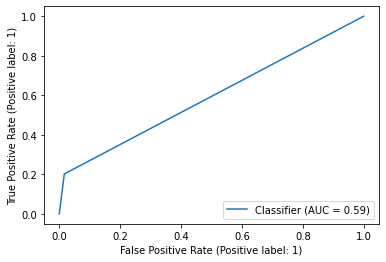

In [29]:
RocCurveDisplay.from_predictions(test.loc[:, 'pi_cat'], KNN_proba[:,1])
plt.show()

In [34]:
f1_score(test.loc[:, 'pi_cat'], preds)

0.203921568627451

In [35]:
accuracy_score(test.loc[:, 'pi_cat'], preds)

0.965166161413945

# Random Forest

In [32]:
RF = RandomForestClassifier(n_jobs= -1, class_weight=None)

RF.fit(X = new_df.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]], y = new_df.loc[:, 'pi_cat'])

RandomForestClassifier(n_jobs=-1)

In [33]:
RF.feature_importances_

array([0.03296648, 0.04533133, 0.02566575, 0.03947096, 0.03668185,
       0.05097841, 0.08610517, 0.0305635 , 0.03925548, 0.02727915,
       0.03714582, 0.03189721, 0.03946026, 0.02434697, 0.03021725,
       0.03872472, 0.02634849, 0.037115  , 0.03181658, 0.03909657,
       0.01870401, 0.03277878, 0.03920642, 0.02788788, 0.03591508,
       0.03526284, 0.04245813, 0.0173199 ])

In [34]:
RF_preds = RF.predict(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])
RF_proba = RF.predict_proba(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])


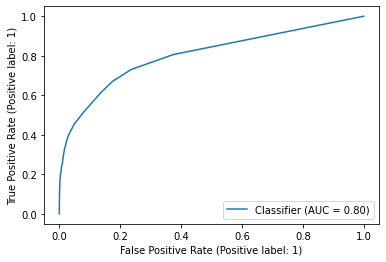

In [46]:
RocCurveDisplay.from_predictions(test.loc[:, 'pi_cat'], RF_proba[:,1])
plt.savefig('rf_roc.png', dpi=300)

In [47]:
confusion_matrix(test.loc[:, 'pi_cat'], RF_preds)

array([[34119,    41],
       [  702,   104]])

In [48]:
f1_score(test.loc[:, 'pi_cat'], RF_preds)
# accuracy_score(test.loc[:, 'pi_cat'], RF_preds)

0.21871713985278654

# LightGBM

In [ ]:
parameters = {'boosting_type':['dart'], 
              'learning_rate':[.3,.4,.5, .6],
              'n_jobs': [-1],
              'class_weight': ['balanced']}

lgbmc = LGBMClassifier()

clf = GridSearchCV(lgbmc, 
                   parameters, 
                   scoring= 'f1',
                   n_jobs=-1)

lgbm_fit = clf.fit(X = new_df.iloc[:, 6:106], y = new_df.loc[:, 'pi_cat'])

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
pd.DataFrame(lgbm_fit.cv_results_)[['params','mean_test_score','rank_test_score']].sort_values('rank_test_score').head(10)

,params,mean_test_score,rank_test_score
0,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.197674,1
1,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.195776,2
3,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.178179,3
2,"{'boosting_type': 'dart', 'class_weight': 'bal...",0.169292,4


In [113]:
lgbmc = LGBMClassifier(boosting_type='dart', learning_rate=.4, n_jobs=-1, class_weight='balanced')

lgbmc.fit(X = new_df.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]], y = new_df.loc[:, 'pi_cat'])

LGBMClassifier(boosting_type='dart', class_weight='balanced', learning_rate=0.4)

In [114]:
LG_preds = lgbmc.predict(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])

In [115]:
LG_proba = lgbmc.predict_proba(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]])

In [116]:
confusion_matrix(test.loc[:, 'pi_cat'], LG_preds)

array([[32598,  1562],
       [  464,   342]])

In [117]:
f1_score(test.loc[:, 'pi_cat'], LG_preds)

0.2523985239852399

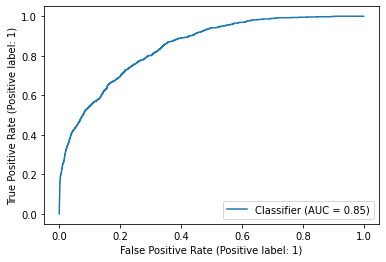

In [119]:
RocCurveDisplay.from_predictions(test.loc[:, 'pi_cat'], LG_proba[:,1])
plt.savefig('lgbm_roc.png', dpi=300)

# GRU

In [6]:
X = np.array(new_df.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]]).reshape(new_df.shape[0],-1, 7)
y = np.array(new_df['pi_cat'])

In [7]:
X_test = np.array(test.iloc[:, [6,7,8,9,12,14,15,
                            36,37,38,39,42,44,45,
                            66,67,68,69,72,74,75,
                            96,97,98,99,102,104,105]]).reshape(test.shape[0],-1,7)
y_test = np.array(test['pi_cat'])

In [14]:
class_weights = {0: 1., 1: 70.}
grumod = Sequential()

grumod.add(LSTM(units = 10, return_sequences = True, input_shape = (4, 7)))
grumod.add(Dropout(0.2))

grumod.add(LSTM(units = 3, return_sequences = False))
grumod.add(Dropout(0.2))

grumod.add(Dense(units = 1, activation='sigmoid'))

grumod.compile(optimizer = 'adam', loss = 'binary_crossentropy')

history = grumod.fit(X, new_df.pi_cat, validation_data=(X_test,test.pi_cat), epochs = 50, batch_size = 512, class_weight = class_weights)

Epoch 1/50
274/274 [==============================] - 5s 9ms/step - loss: 1.1967 - val_loss: 0.5978
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 0.9432 - val_loss: 0.5298
Epoch 3/50
274/274 [==============================] - 2s 7ms/step - loss: 0.8743 - val_loss: 0.4744
Epoch 4/50
274/274 [==============================] - 2s 7ms/step - loss: 0.8502 - val_loss: 0.4661
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 0.8218 - val_loss: 0.4872
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 0.8093 - val_loss: 0.4547
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 0.7864 - val_loss: 0.4656
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 0.7792 - val_loss: 0.4708
Epoch 9/50
274/274 [==============================] - 2s 7ms/step - loss: 0.7726 - val_loss: 0.4758
Epoch 10/50
274/274 [==============================] - 2s 6ms/step - loss: 0.7659 - val_loss: 0.4661

KeyboardInterrupt: ignored

In [15]:
gru_preds = grumod.predict(X_test[:,:10,:])

1093/1093 [==============================] - 4s 3ms/step


In [16]:
confusion_matrix(test.pi_cat,np.round(gru_preds))

array([[27242,  6918],
       [  236,   570]])

In [17]:
f1_score(test.pi_cat,np.round(gru_preds))

0.1374487581384133

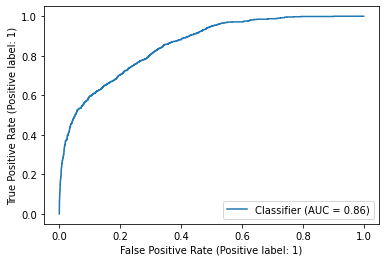

In [18]:
RocCurveDisplay.from_predictions(test.pi_cat,gru_preds)
plt.savefig('gru_roc.png', dpi=300)